In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from numpy.random import choice, uniform, normal
from astropy import units as u
from astropy.coordinates import SkyCoord
import pandas as pd
from statistics import NormalDist
from scipy.stats import norm, chisquare

In [2]:
#constants
me= 0.511 #MeV/c^2
r0 = 2.81810e-13 #classical el rad, cm
hc= 1.242 #eV * um
q_e=1.602*1e-19 #charge of electron

In [3]:
#Nishina-Klein angular distr
def a(Ei, theta): #a=Ef/Ei for photon
    return me/(Ei*(1- np.cos(theta))+me)

def diffxsect(theta,Ei,deg=0):
    if deg==1: theta=theta*np.pi/180
    c=r0**2/2
    a_i=a(Ei,theta)
    dsdo=c*(a_i**2)*(a_i+(1/a_i)-(np.sin(theta))**2)
    return dsdo

def xsect_dist(Ei, norm=1): #Ei in MeV, norm=normalized
    theta=np.linspace(0,2*np.pi,num=100)
    dxc=[]
    for t in theta: dxc.append(diffxsect(t,Ei))
    s=sum(dxc)
    if norm==1: 
        norm_dxc=dxc/s
        return theta, norm_dxc
    else: 
        return theta, dxc

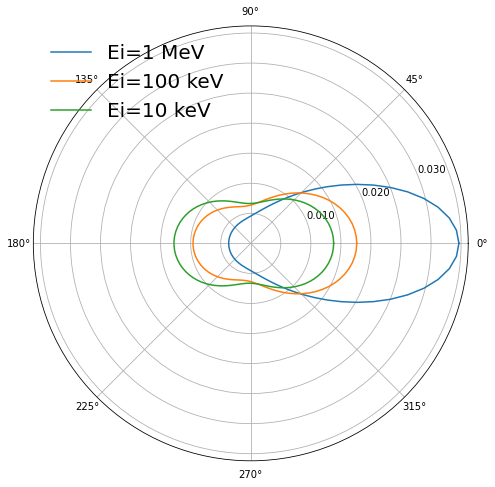

In [4]:
#normalized angular PDF, from Nishina-Klein
fig, ax = plt.subplots(figsize=(12,8),subplot_kw=dict(polar=True))

th, dxc10 = xsect_dist(10)
th, dxc1 = xsect_dist(1)
th, dxc100k=xsect_dist(0.1)
th, dxc10k=xsect_dist(0.01)

plt.plot(th, dxc1, label='Ei=1 MeV')
plt.plot(th, dxc100k, label='Ei=100 keV')
plt.plot(th, dxc10k, label='Ei=10 keV')
plt.setp(ax.get_yticklabels()[::2], visible=False)

plt.legend(loc=2,fontsize=20, frameon=False)
plt.show()
#plt.savefig('./scatt_ang_pdf.png')

In [4]:
#fxn for ef and positions once angular value is drawn
#eqns/defn from Boggs &Jean
def ef(th,ei):
    return ei/(1+ei/me*(1-np.cos(th)))

def phi1(th,ei):
    w0=ei/me
    w1=ef(th,ei)/me
    return np.arccos(1+(1/w0)-(1/w1))

def r1hat(r2,r1):
    r1p=[r2[0]-r1[0],r2[1]-r1[1]]
    return r1p/np.sqrt(r1p[0]**2+r1p[1]**2)

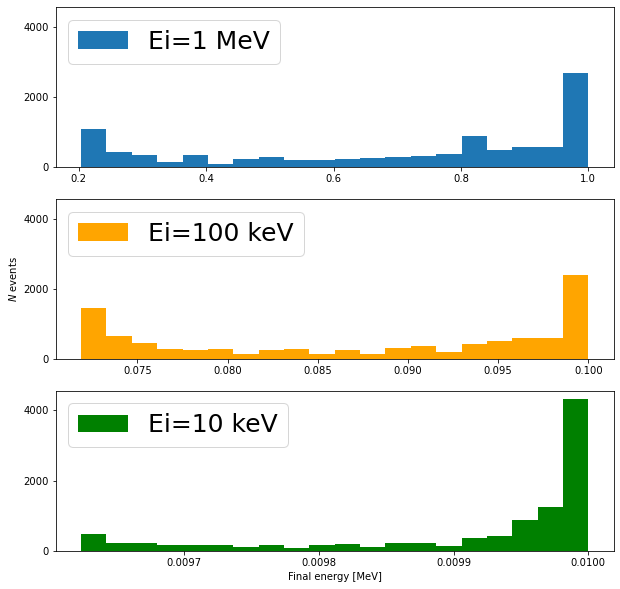

In [6]:
#checking random draws with prob fxn
theta=np.linspace(0,2*np.pi,num=100)
draw = choice(theta, 10000, p=dxc1)
draw2 = choice(theta, 10000, p=dxc100k)
draw3=choice(theta,10000,p=dxc10k)

fig, ax = plt.subplots(3,figsize=(10,10),sharey=True)
ax[0].hist(ef(draw,1), bins=20, label='Ei=1 MeV')
ax[1].set(ylabel='$N$ events')
ax[1].hist(ef(draw2,0.1), color='orange', bins=20, label='Ei=100 keV')
ax[2].hist(ef(draw,0.01), color='g', bins=20, label='Ei=10 keV')
plt.rcParams.update({'font.size': 25})
plt.xlabel(r'Final energy [MeV]')

ax[0].legend(loc=2)
ax[1].legend(loc=2)
ax[2].legend(loc=2)
plt.savefig('./ef_dist.png')

In [5]:
#start fixing here: all same ra
def gen_posdata(th,ei): #n_events is flux*energy: counts/s
    #ra and dec in std units (hourangle, deg)
    source=SkyCoord('05:34:31.94','+22:00:52.2',unit=(u.hourangle,u.deg))
    ra=source.ra.deg
    dec=source.dec.deg
    
    h=1 # repl with comptel height
    size=65.6 #repl with comptel det size
    p1=phi1(th,ei)
    
    theta1=uniform(low=0,high=2*np.pi)
    xi = uniform(low=-0.5*size,high=0.5*size)
    yi = uniform(low=-0.5*size,high=0.5*size)

    xf=xi+np.sqrt(h*(1-h*np.cos(p1))/(abs(np.cos(p1))*(1+np.tan(theta1)**2)))
    yf=yi+(xf-xi)*np.tan(theta1)
    posi=[xi,yi]
    posf=[xf,yf]
    
    return posi, posf, [ra,dec]

sigmaE=0.088/(2*np.sqrt(2*np.log(2)))

def ang_unc(ei,th,phi):
    w0=ei/me
    w1=ef(th,ei)/me
    
    term1=sigmaE**2/(w0**2)
    term2=((1/(w1**2)-1/(w0**2))**2-1/(w0**4))*(sigmaE*w1)**2
    
    return (1/np.sin(phi))*(term1+term2)**(1/2)

In [6]:
#to encorporate angular uncertainty in data units, rather than points
#from the internet: 
#https://stackoverflow.com/questions/19394505/expand-the-line-with-specified-width-in-data-unit/42972469#42972469

class data_linewidth_plot():
    def __init__(self, x, y, **kwargs):
        self.ax = kwargs.pop("ax", plt.gca())
        self.fig = self.ax.get_figure()
        self.lw_data = kwargs.pop("linewidth", 1)
        self.lw = 1
        self.fig.canvas.draw()

        self.ppd = 72./self.fig.dpi
        self.trans = self.ax.transData.transform
        self.linehandle, = self.ax.plot([],[],**kwargs)
        if "label" in kwargs: kwargs.pop("label")
        self.line, = self.ax.plot(x, y, **kwargs)
        self.line.set_color(self.linehandle.get_color())
        self._resize()
        self.cid = self.fig.canvas.mpl_connect('draw_event', self._resize)

    def _resize(self, event=None):
        lw =  ((self.trans((1, self.lw_data))-self.trans((0, 0)))*self.ppd)[1]
        if lw != self.lw:
            self.line.set_linewidth(lw)
            self.lw = lw
            self._redraw_later()

    def _redraw_later(self):
        self.timer = self.fig.canvas.new_timer(interval=10)
        self.timer.single_shot = True
        self.timer.add_callback(lambda : self.fig.canvas.draw_idle())
        self.timer.start()

In [20]:
#used to get uncertainties for reconstruction location via MC method
#function is iterative
def norm_err(x,y,x2,y2,dw):
    for v in x: 
        xsig_err=normal(v,scale=dw,size=1000)
        for c in xsig_err: x2.append(c)
    for v2 in y:
        ysig_err=normal(v2,scale=dw,size=1000)
        for c2 in ysig_err: y2.append(c2)
    return x2, y2

#calc location, from arrays of all values along path
def reconstr_loc(x2,y2,show_plt=0):
    h,xedges, yedges=np.histogram2d(y2,x2,bins=100)
    if show_plt==1: 
        fig, ax = plt.subplots(figsize=(12,8))
        plt.imshow(h, interpolation='nearest', origin='lower',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    sig1=np.where(h>=0.5*h.max())
    maxh=np.where(h==h.max())
    xerr=(max(xedges[sig1[0]])-min(xedges[sig1[0]]))/2
    yerr=(max(xedges[sig1[1]])-min(xedges[sig1[1]]))/2
    loc=[xedges[maxh[0][0]],yedges[maxh[1][0]]]
    loc_err=[xerr,yerr]
    return loc, loc_err

In [8]:
#most important function: calls all others to create complete reconstruction
def draw_reconstr(n,ei=0,spect=False,print_fig=0,show_plt=True):
    if ei==0 and spect==False: 
        print('Error: need either nonzero value for ei or spectrum=True')
        return
    
    if show_plt==True: fig, ax = plt.subplots(figsize=(12,8))#,subplot_kw=dict(polar=True))
    n_recon=0
    maxp=0
    x2=[]
    y2=[]
    for i in range(n):
        if spect==True: 
            ei=choice(crabE,1,p=n_pdf)
            ei=ei[0]
        th, dxc = xsect_dist(ei)
        draw = choice(th, 1, p=dxc)
        
        if draw[0]==0.0 or draw[0]==np.pi or draw[0]==2*np.pi:continue 
            #skip iteration if value gives inf error
        phi=phi1(draw[0],ei)
        
        posi,posf,source =gen_posdata(draw[0],ei)
        r=r1hat(posi,posf)
        dw=ang_unc(ei,draw[0],phi)
        
        th_1=np.arctan(r[1]/r[0])
        az_phi=np.linspace(th_1-(np.pi/2),th_1-(3*np.pi/2),num=100)

        t=np.tan(phi)*np.cos(th_1-az_phi)
        phi_2=np.arccos(1-t**2/(1+t**2))
        x1=(phi_2)*np.cos(az_phi)
        y1=(phi_2)*np.sin(az_phi)
        if i==0: maxp=max(phi_2)
        else: 
            if max(phi_2)>maxp: maxp=max(phi_2)
        if dw < 0.5:
            if show_plt==True:
                l = data_linewidth_plot(y1+source[0], x1+source[1],ax=ax,
                    linewidth=dw, alpha=0.4, color='pink')
                plt.plot(y1+source[0],x1+source[1],color='r')
            x2,y2=norm_err(x1,y1,x2,y2,dw)
            n_recon+=1
    loc,locerr=reconstr_loc(x2+source[1],y2+source[0])
    if show_plt==True:
        plt.plot(source[0],source[1],'b*')
        plt.ylabel(r'Declination [$^o$]')
        plt.xlabel(r'RA [$^o$]')
        a=ax.axis()
        ax.text((a[1]-a[0])*0.68+a[0], (a[3]-a[2])*0.85+a[2], 
                r'RA: %.2f $\pm$ %.2f''\n'r'  $\delta$: %.2f $\pm$ %.2f'%(loc[0],locerr[0],loc[1],locerr[1]))
        if spect == False: plt.title('N reconstructed events: %i, Ei = %.1f MeV'%(n_recon,ei))
        else: plt.title('N reconstructed events: %i'%n_recon)
        if print_fig==1 and spect==False: plt.savefig('./circ_reconstr''%i''.png'%ei)
        elif print_fig==1 and spect==True: plt.savefig('./spect_reconstr.png')
        else: plt.show()
    return loc, locerr

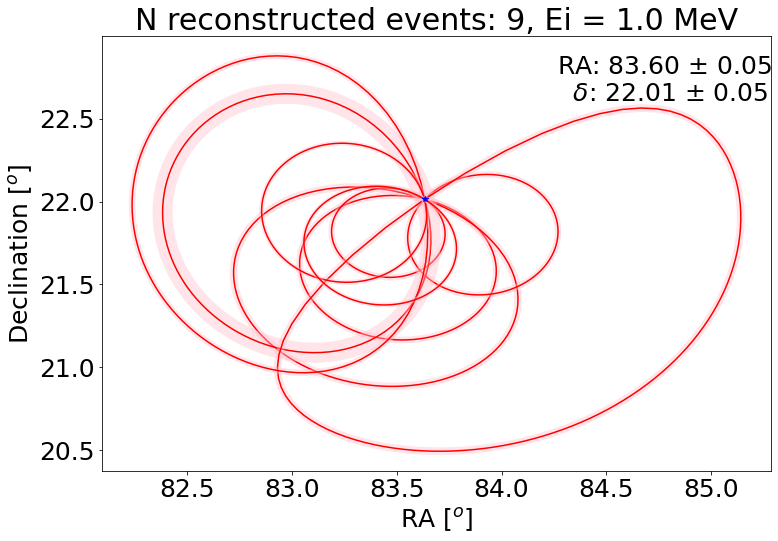

([83.60126297982593, 22.009791403431933],
 [0.049778688057884324, 0.04977868805789143])

In [11]:
#draw_reconstr(10,5,print_fig=1)
draw_reconstr(10,ei=1) 

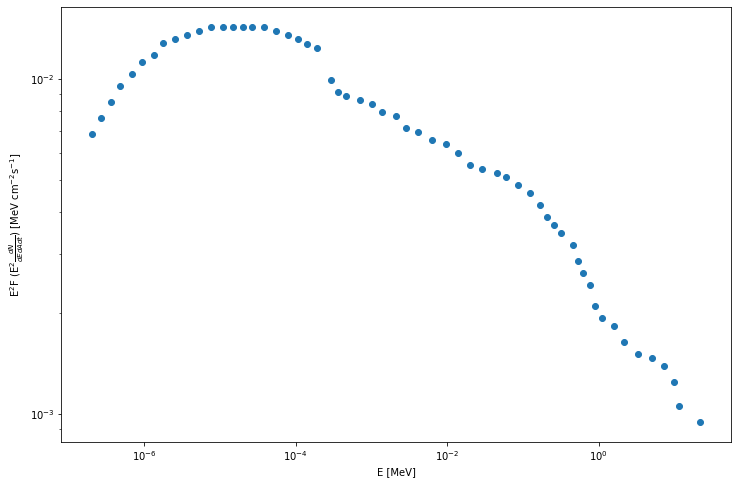

In [9]:
crab_spect = pd.read_csv('./crab_xray.csv',
        header=0,names=['E','E2flux'])

fig, ax = plt.subplots(figsize=(12,8))
plt.plot(crab_spect['E']*1e3,crab_spect['E2flux']*1e6,'o')
plt.xlabel('E [MeV]')
plt.ylabel(r'E$^2$F (E$^2\frac{dN}{dEdAdt}$) [MeV cm$^{-2}$s$^{-1}$]')
plt.semilogx()
plt.semilogy()
#plt.show()
plt.savefig('./crab_spectrum_full.png')

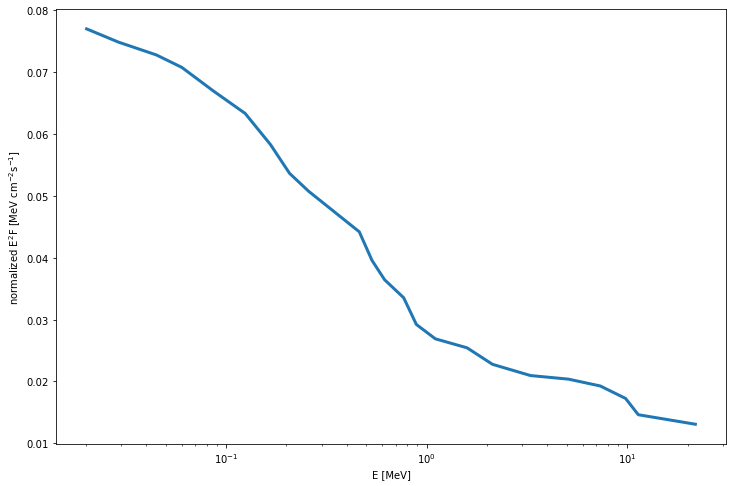

In [10]:
#PDF of energies for Crab
#integrating over area of upper COMPTEL disc: 4300cm^2
msk1=crab_spect['E']*1e3>0.02
msk2=crab_spect['E']*1e3<30

flux=[crab_spect['E2flux'][i]/1e3*4300 for i in range(len(crab_spect['E']))]
wh=np.where(msk1&msk2==True)

crabF=[flux[w] for w in wh[0]]
crabE=[crab_spect['E'][w]*1e3 for w in wh[0]]

#integrating over energy bins
#dn=[]
#for i in range(len(crabE)-1):
#    dn.append(abs(crabF[i+1]/crabE[i]**2*(crabE[i+1]-crabE[i])))
#N=sum(dn)
#n_pdf=[n/N for n in dn]
N=sum(crabF)
n_pdf=[n/N for n in crabF]

fig, ax = plt.subplots(figsize=(12,8))
plt.plot(crabE[0:-1],n_pdf[0:-1],lw=3)
#plt.plot(crabE[0:-1],n_pdf,'o')
plt.xlabel('E [MeV]')
plt.ylabel(r'normalized E$^2$F [MeV cm$^{-2}$s$^{-1}$]')
plt.semilogx()
plt.savefig('./crab_spect_norm.png')
#plt.show()

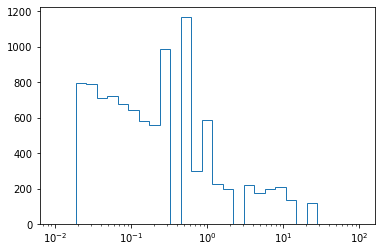

In [11]:
draw = choice(crabE, 10000, p=n_pdf)
histbins=np.logspace(-2,2,num=30)
plt.hist(draw, histtype='step', bins=histbins)
plt.xscale('log')

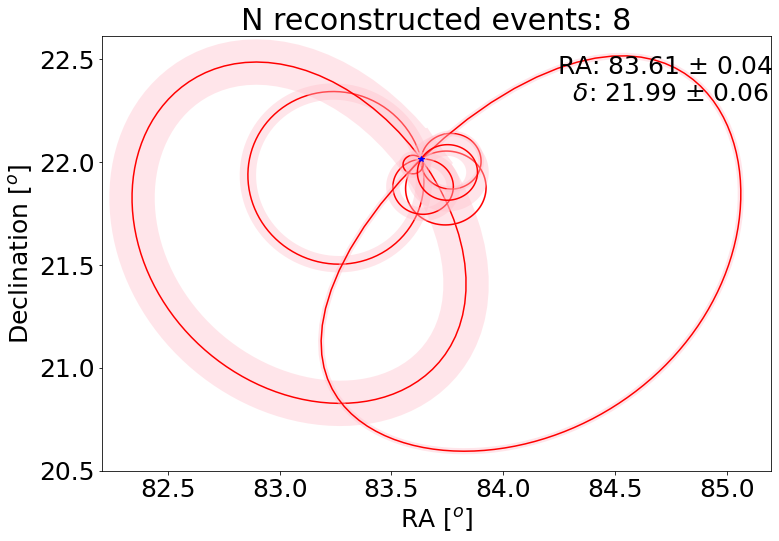

([83.6072534368904, 21.98876808410394],
 [0.03694808723539467, 0.05542213085308845])

In [15]:
#draw_reconstr(10,spect=True, print_fig=1)
draw_reconstr(10,spect=True)

In [16]:
# look at trial variation: run 100 reconstructions and save locations and error to look at trial variation
def run_trials(n):
    pos={'ra':[],'ra_unc':[],'dec':[],'dec_unc':[]}
    for i in range(n):
        if (i+1)%int(n/20)==0: print('Trial: ',i+1)
        loc, err=draw_reconstr(10,spect=True,show_plt=False)
        pos['ra'].append(loc[0])
        pos['dec'].append(loc[1])
        pos['ra_unc'].append(err[0])
        pos['dec_unc'].append(err[1])
        if i==(n-1): print('Done.')
    return pos

In [37]:
#DON'T RUN ME (unless you want to sit awhile)
pos=run_trials(100)

Trial:  5
Trial:  10
Trial:  15
Trial:  20
Trial:  25
Trial:  30
Trial:  35
Trial:  40
Trial:  45
Trial:  50
Trial:  55
Trial:  60
Trial:  65
Trial:  70
Trial:  75
Trial:  80
Trial:  85
Trial:  90
Trial:  95
Trial:  100
Done.


In [38]:
gaussra = NormalDist.from_samples(pos['ra'])
gaussdec= NormalDist.from_samples(pos['dec'])
gaussdra= NormalDist.from_samples(pos['ra_unc'])
gaussddec= NormalDist.from_samples(pos['dec_unc'])

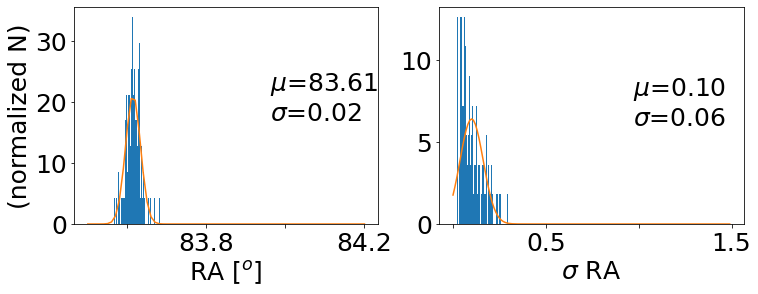

In [39]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].hist(pos['ra'],bins=50,density=True)
plt.setp(ax[0].get_xticklabels()[1::2], visible=False)
rabins=np.arange(83.5,84.2,0.01)
ax[0].plot(rabins,norm.pdf(rabins,gaussra.mean,gaussra.stdev))
ax[0].text(83.96, 17, r'$\mu$=%.2f''\n'r'$\sigma$=%.2f'%(gaussra.mean,gaussra.stdev))
ax[0].set_xlabel('RA [$^o$]')
ax[0].set_ylabel(r'(normalized N)')

ax[1].hist(pos['ra_unc'],bins=50,density=True)
plt.setp(ax[1].get_xticklabels()[1::2], visible=False)
ax[1].set_xlabel(r'$\sigma$ RA')
ax[1].plot(np.arange(0,1.5,0.01),norm.pdf(np.arange(0,1.5,0.01),gaussdra.mean,gaussdra.stdev))
ax[1].text(0.97, 6, r'$\mu$=%.2f''\n'r'$\sigma$=%.2f'%(gaussdra.mean,gaussdra.stdev))

plt.savefig('./trial_var_ra.png')

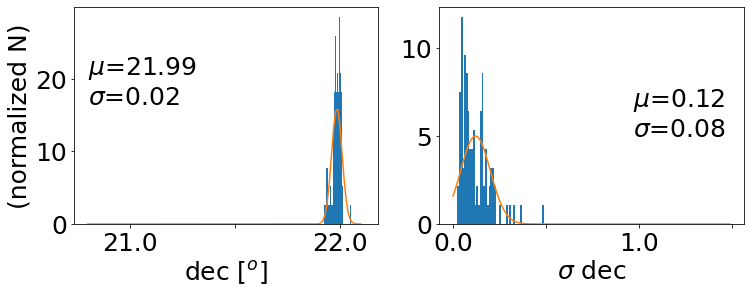

In [40]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].hist(pos['dec'],bins=50,density=True)
plt.setp(ax[0].get_xticklabels()[::2], visible=False)

ax[0].plot(np.arange(20.8,22.1,0.01),norm.pdf(np.arange(20.8,22.1,0.01),gaussdec.mean,gaussdec.stdev))
ax[0].text(20.8, 16.5, r'$\mu$=%.2f''\n'r'$\sigma$=%.2f'%(gaussdec.mean,gaussdec.stdev))
ax[0].set_xlabel('dec [$^o$]')
ax[0].set_ylabel(r'(normalized N)')

ax[1].hist(pos['dec_unc'],bins=50,density=True)
plt.setp(ax[1].get_xticklabels()[::2], visible=False)
ax[1].set_xlabel(r'$\sigma$ dec')
ax[1].plot(np.arange(0,1.5,0.01),norm.pdf(np.arange(0,1.5,0.01),gaussddec.mean,gaussddec.stdev))
ax[1].text(0.97, 5, r'$\mu$=%.2f''\n'r'$\sigma$=%.2f'%(gaussddec.mean,gaussddec.stdev))

#plt.show()
plt.savefig('./trial_var_dec.png')

In [12]:
source=SkyCoord('05:34:31.94','+22:00:52.2',unit=(u.hourangle,u.deg))
source

<SkyCoord (ICRS): (ra, dec) in deg
    (83.63308333, 22.0145)>

In [18]:
fbinsd=np.linspace(20.6,22.3,num=100)
fobsd=np.histogram(pos['dec'],bins=fbinsd,density=True)
fexpd=norm.pdf(fbinsd,gaussdec.mean,gaussdec.stdev)
chisquare(fobsd[0],f_exp=fexpd[0:-1],ddof=2)

NameError: name 'pos' is not defined

In [472]:
fbinsra=np.linspace(83,84.5,num=100)
fobsra=np.histogram(pos['ra'],bins=fbinsra,density=True)
fexpra=norm.pdf(fbinsra,gaussra.mean,gaussra.stdev)
chisquare(fobsra[0],f_exp=fexpra[0:-1],ddof=2)

Power_divergenceResult(statistic=1.7140550360088545e+71, pvalue=0.0)

#### Show plots for each step: presentation

In [42]:
#identical method to above draw_reconstr, just with extra printed plot
def method_show(n):
    spect=True
    plt.rcParams.update({'font.size': 25})
    
    maxp=0
    n_recon=0
    x2=[]
    y2=[]
    for i in range(n):
        ei=choice(crabE,1,p=n_pdf)
        ei=ei[0]
        th, dxc = xsect_dist(ei)
        draw = choice(th, 1, p=dxc)

        phi=phi1(draw[0],ei)

        if i==0: 
            fig, ax = plt.subplots(figsize=(12,8),subplot_kw=dict(polar=True))
            plt.plot(th, dxc, label='Ei=%.3f MeV'%ei)
            w=np.where(th==draw[0])
            plt.plot(th[w[0]],dxc[w[0]], 'ro', label='theta=%.3f rad'%draw[0])
            plt.setp(ax.get_yticklabels()[::2], visible=False)

            plt.legend(loc=0,fontsize=20)
            plt.savefig('./ang_pdf_1e.png')
        
        posi,posf,source =gen_posdata(draw[0],ei)
        r=r1hat(posi,posf)
        dw=ang_unc(ei,draw[0],phi)

        print('Pos (x,y): (%.3f cm,%.3f cm)'%(posf[0],posf[1]))
        print('r: (%.3f,%.3f)'%(r[0],r[1]))
        
        th_1=np.arctan(r[1]/r[0])
        az_phi=np.linspace(th_1-(np.pi/2),th_1-(3*np.pi/2),num=100)

        t=np.tan(phi)*np.cos(th_1-az_phi)
        phi_2=np.arccos(1-t**2/(1+t**2))
        x1=(phi_2)*np.cos(az_phi)
        y1=(phi_2)*np.sin(az_phi)
        maxp=max(phi_2)

        if dw < 0.5:
            if i==0:
                fig, ax = plt.subplots(figsize=(8,8))
                l = data_linewidth_plot(y1+source[0], x1+source[1],ax=ax,linewidth=dw, alpha=0.4, color='pink')
                plt.plot(y1+source[0],x1+source[1],color='r')
                x2,y2=norm_err(x1,y1,x2,y2,dw)
                plt.plot(source[0],source[1],'b*')
                plt.ylabel(r'Declination [$^o$]')
                plt.xlabel(r'RA [$^o$]')
                plt.savefig('./circ1e.png')
    
                loc,locerr=reconstr_loc(x2+source[1],y2+source[0],show_plt=1)
                plt.plot(source[0],source[1],'b*')
                plt.ylabel(r'Declination [$^o$]')
                plt.xlabel(r'RA [$^o$]')
                a=ax.axis()
                ax.text((a[1]-a[0])*0.68+a[0], (a[3]-a[2])*0.85+a[2], 
                    r'RA: %.2f $\pm$ %.2f''\n'r'  $\delta$: %.2f $\pm$ %.2f'%(loc[0],locerr[0],loc[1],locerr[1]))
                plt.savefig('./2dhist.png')

Pos (x,y): (4.917 cm,30.070 cm)
r: (-0.411,0.912)


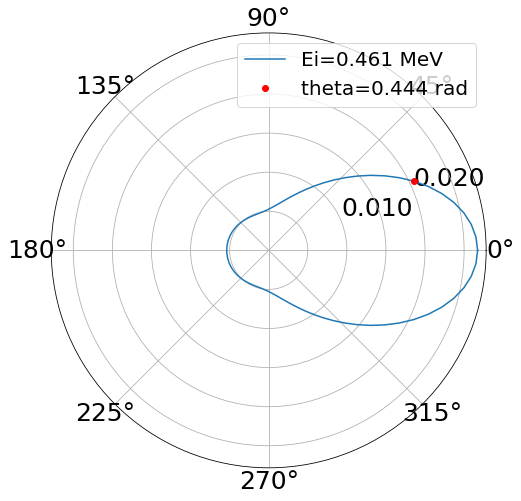

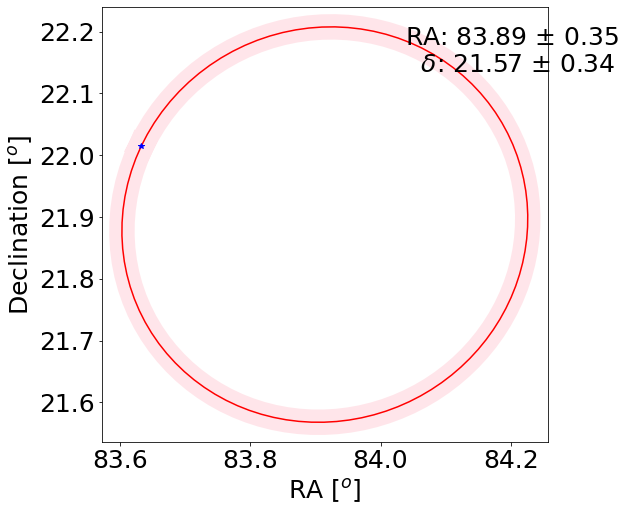

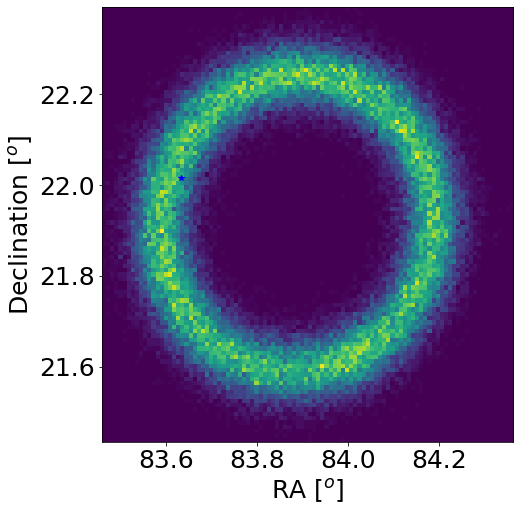

In [43]:
method_show(1)